In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import data using datetime and set index to datetime
df = pd.read_csv(r'C:\Users\91783\Desktop\Bhiwadi_hourly\pollutants.CSV',
                                parse_dates=['DateTime'],
                                index_col=['DateTime'])

df.head()

,PM2.5,PM10,NO,NO2,SO2,CO,Ozone
DateTime,,,,,,,
2021-01-01 00:00:00,389.82,636.00,38.56,58.10,16.39,2.16,11.52
2021-01-01 01:00:00,396.16,635.55,24.84,53.81,22.61,1.25,13.61
2021-01-01 02:00:00,332.44,519.05,37.31,57.53,24.74,1.24,6.55
2021-01-01 03:00:00,274.54,453.33,22.92,49.74,9.11,1.37,5.68
2021-01-01 04:00:00,294.05,446.65,19.70,36.77,11.29,1.64,6.87


<AxesSubplot:>

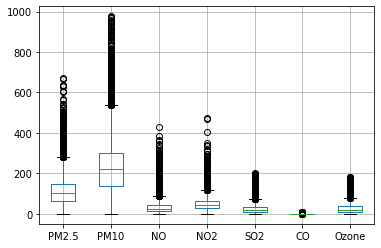

In [3]:
#Box plot
#pd.options.display.mpl_style = False
df.boxplot()

In [4]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = df.values
encoder = LabelEncoder()
values[:,6] = encoder.fit_transform(values[:,6])
values = values.astype('float32')
values[:,6]

array([1053., 1250.,  566., ..., 2307., 2307., 2307.], dtype=float32)

In [5]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [6]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [7]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (12829, 1)
X (12829, 4, 7)


In [8]:
#Splitting the dataset 365*.2=73 and 365-73=292
n_train = 3848
X_train, X_test = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (8981, 4, 7)
X_test (3848, 4, 7)
Y_train (8981, 1)
Y_test (3848, 1)


In [9]:
#Importing LSTM model
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
import tensorflow as tf
model = Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

#model.compile(optimizer = 'adam', loss = 'mean_squared_error')     
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mean_squared_error', optimizer=opt)

In [10]:
def call(c):
    history = model.fit(X_train, Y_train, epochs=c,
                    batch_size=32, validation_data=(X_test,Y_test),
                    verbose=2, shuffle=False)
        # plot train and validation loss
    from matplotlib import pyplot
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()
    Y_pred = model.predict(X_test)

    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(Y_test, Y_pred)
    print(mse)

    rmse = np.sqrt(mse)
    print(rmse)
    
    #fn
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(Y_test, Y_pred)
    print('MAPE', mape)

Epoch 1/50
281/281 - 19s - loss: 0.1531 - val_loss: 0.0106 - 19s/epoch - 69ms/step
Epoch 2/50
281/281 - 3s - loss: 0.0410 - val_loss: 0.0207 - 3s/epoch - 11ms/step
Epoch 3/50
281/281 - 3s - loss: 0.0519 - val_loss: 0.0179 - 3s/epoch - 11ms/step
Epoch 4/50
281/281 - 4s - loss: 0.0659 - val_loss: 0.0436 - 4s/epoch - 13ms/step
Epoch 5/50
281/281 - 3s - loss: 0.0596 - val_loss: 0.0363 - 3s/epoch - 12ms/step
Epoch 6/50
281/281 - 3s - loss: 0.0541 - val_loss: 0.0217 - 3s/epoch - 12ms/step
Epoch 7/50
281/281 - 3s - loss: 0.0574 - val_loss: 0.0817 - 3s/epoch - 12ms/step
Epoch 8/50
281/281 - 4s - loss: 0.0580 - val_loss: 0.0205 - 4s/epoch - 13ms/step
Epoch 9/50
281/281 - 4s - loss: 0.0593 - val_loss: 0.0634 - 4s/epoch - 13ms/step
Epoch 10/50
281/281 - 3s - loss: 0.0629 - val_loss: 0.0328 - 3s/epoch - 11ms/step
Epoch 11/50
281/281 - 3s - loss: 0.0636 - val_loss: 0.0739 - 3s/epoch - 11ms/step
Epoch 12/50
281/281 - 4s - loss: 0.0558 - val_loss: 0.0349 - 4s/epoch - 13ms/step
Epoch 13/50
281/281 - 3

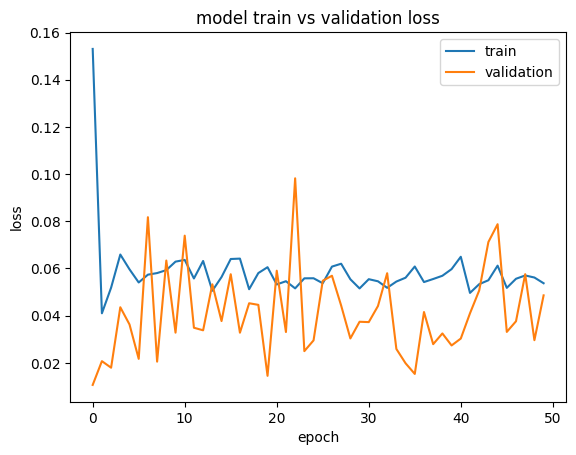

121/121 [==============================] - 3s 4ms/step
0.048595168
0.22044311
MAPE 232.3174238204956
Epoch 1/100
281/281 - 3s - loss: 0.0531 - val_loss: 0.0638 - 3s/epoch - 11ms/step
Epoch 2/100
281/281 - 3s - loss: 0.0612 - val_loss: 0.0301 - 3s/epoch - 11ms/step
Epoch 3/100
281/281 - 3s - loss: 0.0561 - val_loss: 0.0211 - 3s/epoch - 11ms/step
Epoch 4/100
281/281 - 3s - loss: 0.0610 - val_loss: 0.0106 - 3s/epoch - 12ms/step
Epoch 5/100
281/281 - 3s - loss: 0.0471 - val_loss: 0.0522 - 3s/epoch - 12ms/step
Epoch 6/100
281/281 - 3s - loss: 0.0601 - val_loss: 0.0308 - 3s/epoch - 11ms/step
Epoch 7/100
281/281 - 3s - loss: 0.0566 - val_loss: 0.0418 - 3s/epoch - 11ms/step
Epoch 8/100
281/281 - 3s - loss: 0.0547 - val_loss: 0.0494 - 3s/epoch - 11ms/step
Epoch 9/100
281/281 - 3s - loss: 0.0557 - val_loss: 0.0648 - 3s/epoch - 12ms/step
Epoch 10/100
281/281 - 3s - loss: 0.0541 - val_loss: 0.0493 - 3s/epoch - 12ms/step
Epoch 11/100
281/281 - 3s - loss: 0.0528 - val_loss: 0.0264 - 3s/epoch - 12ms/

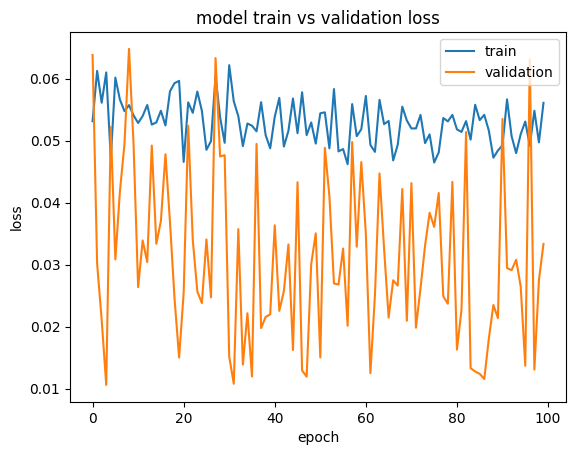

121/121 [==============================] - 0s 4ms/step
0.033321433
0.1825416
MAPE 195.6566333770752
Epoch 1/150
281/281 - 3s - loss: 0.0480 - val_loss: 0.0458 - 3s/epoch - 11ms/step
Epoch 2/150
281/281 - 3s - loss: 0.0499 - val_loss: 0.0367 - 3s/epoch - 11ms/step
Epoch 3/150
281/281 - 3s - loss: 0.0538 - val_loss: 0.0354 - 3s/epoch - 11ms/step
Epoch 4/150
281/281 - 4s - loss: 0.0481 - val_loss: 0.0238 - 4s/epoch - 13ms/step
Epoch 5/150
281/281 - 4s - loss: 0.0526 - val_loss: 0.0114 - 4s/epoch - 13ms/step
Epoch 6/150
281/281 - 4s - loss: 0.0596 - val_loss: 0.0268 - 4s/epoch - 13ms/step
Epoch 7/150
281/281 - 3s - loss: 0.0559 - val_loss: 0.0161 - 3s/epoch - 12ms/step
Epoch 8/150
281/281 - 3s - loss: 0.0497 - val_loss: 0.0126 - 3s/epoch - 12ms/step
Epoch 9/150
281/281 - 3s - loss: 0.0553 - val_loss: 0.0177 - 3s/epoch - 11ms/step
Epoch 10/150
281/281 - 3s - loss: 0.0506 - val_loss: 0.0225 - 3s/epoch - 12ms/step
Epoch 11/150
281/281 - 3s - loss: 0.0479 - val_loss: 0.0324 - 3s/epoch - 12ms/s

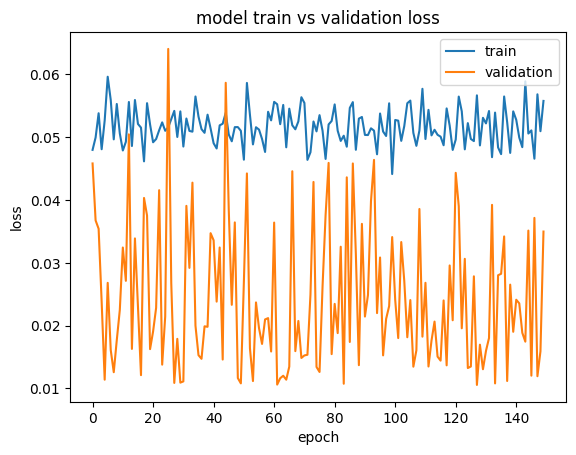

121/121 [==============================] - 1s 5ms/step
0.03497737
0.18702237
MAPE 200.09171962738037
Epoch 1/200
281/281 - 4s - loss: 0.0454 - val_loss: 0.0135 - 4s/epoch - 13ms/step
Epoch 2/200
281/281 - 4s - loss: 0.0506 - val_loss: 0.0250 - 4s/epoch - 14ms/step
Epoch 3/200
281/281 - 4s - loss: 0.0507 - val_loss: 0.0240 - 4s/epoch - 14ms/step
Epoch 4/200
281/281 - 4s - loss: 0.0483 - val_loss: 0.0335 - 4s/epoch - 14ms/step
Epoch 5/200
281/281 - 4s - loss: 0.0532 - val_loss: 0.0368 - 4s/epoch - 14ms/step
Epoch 6/200
281/281 - 4s - loss: 0.0504 - val_loss: 0.0402 - 4s/epoch - 15ms/step
Epoch 7/200
281/281 - 4s - loss: 0.0521 - val_loss: 0.0260 - 4s/epoch - 15ms/step
Epoch 8/200
281/281 - 4s - loss: 0.0554 - val_loss: 0.0140 - 4s/epoch - 13ms/step
Epoch 9/200
281/281 - 4s - loss: 0.0477 - val_loss: 0.0117 - 4s/epoch - 14ms/step
Epoch 10/200
281/281 - 4s - loss: 0.0504 - val_loss: 0.0243 - 4s/epoch - 14ms/step
Epoch 11/200
281/281 - 4s - loss: 0.0492 - val_loss: 0.0510 - 4s/epoch - 13ms/

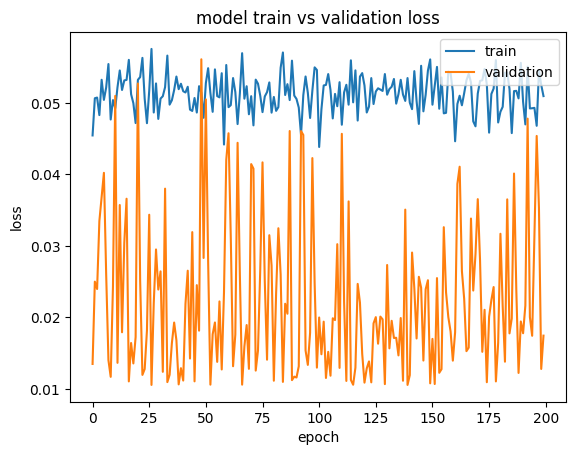

121/121 [==============================] - 1s 4ms/step
0.017452633
0.13210842
MAPE 141.9250249862671
Epoch 1/250
281/281 - 4s - loss: 0.0510 - val_loss: 0.0285 - 4s/epoch - 14ms/step
Epoch 2/250
281/281 - 4s - loss: 0.0552 - val_loss: 0.0141 - 4s/epoch - 14ms/step
Epoch 3/250
281/281 - 4s - loss: 0.0499 - val_loss: 0.0175 - 4s/epoch - 14ms/step
Epoch 4/250
281/281 - 4s - loss: 0.0488 - val_loss: 0.0580 - 4s/epoch - 14ms/step
Epoch 5/250
281/281 - 4s - loss: 0.0521 - val_loss: 0.0197 - 4s/epoch - 14ms/step
Epoch 6/250
281/281 - 4s - loss: 0.0529 - val_loss: 0.0160 - 4s/epoch - 14ms/step
Epoch 7/250
281/281 - 4s - loss: 0.0533 - val_loss: 0.0195 - 4s/epoch - 14ms/step
Epoch 8/250
281/281 - 4s - loss: 0.0517 - val_loss: 0.0286 - 4s/epoch - 14ms/step
Epoch 9/250
281/281 - 4s - loss: 0.0538 - val_loss: 0.0117 - 4s/epoch - 14ms/step
Epoch 10/250
281/281 - 4s - loss: 0.0481 - val_loss: 0.0124 - 4s/epoch - 14ms/step
Epoch 11/250
281/281 - 4s - loss: 0.0505 - val_loss: 0.0333 - 4s/epoch - 14ms/

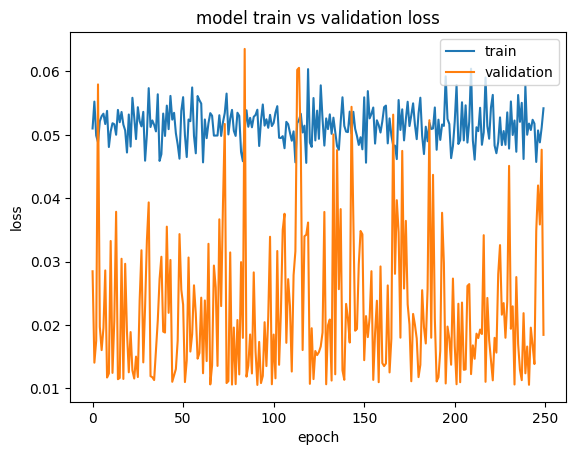

121/121 [==============================] - 1s 6ms/step
0.01845433
0.13584672
MAPE 146.33314609527588


In [11]:
l=[50,100,150,200,250]
for i in l:
    call(i)